# Data Merge
This notebook describes steps to pull the stats from the txt files and combine them to create the final data structure.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
from collections import OrderedDict
from datetime import datetime

### Location Path
Define the location of files here.

In [78]:
DATA_PATH = '/Users/stereopickles/CU_Google_Drive/COLUMBIA/DSI-Schizo/Data2020/DATA040320'
HC_PATH = f"{DATA_PATH}/HC/COBRE_prep/HC_Stats"
SZ_PATH = f"{DATA_PATH}/SZ/COBRE_prep/SZ_Stats"
HC_FAT_DTI_PATH = f'{HC_PATH}/FAT'
SZ_FAT_DTI_PATH = f'{SZ_PATH}/FAT'
HC_UF_DTI_PATH = f'{HC_PATH}/UF'
SZ_UF_DTI_PATH = f'{SZ_PATH}/UF'

In [79]:
TRACTS = ['FAT', 'UF']
CONDS = ['SZ', 'HC']

In [80]:
# full subject lists

with open(f'{DATA_PATH}/subject_list.txt', 'r') as f: 
    subjects = f.read()
    
subjects = [re.sub('A', '', x) for x in subjects.split('\n')]

### Extract stats 
The resulting table should look like 
| subnum | admin | condition | tract | datetime | side | track_count | voxel_count | mean_length | mean_FA_trk | mean_Ang | mean_FA | mean_AD | mean_MD | mean_RD | 

In [81]:
def find_num(str_):
    return int(re.findall('(?<=: )([.0-9]*)', str_)[0])

def find_mean_se(str_):
    mean = float([x if x != 'nan' else 0 for x in re.findall('(?<=: )([na.0-9]*)', str_)][0])
    se = float(re.findall('(?<=- )([.0-9]*)', str_)[0])
    return mean, se

def find_type(str_):
    return re.findall('(?<=DTI_)([A-Z]*)', str_)[0]

def find_year(str_):
    return int(re.findall('(?<=ses-)([0-9]*)', str_)[0][:4])

In [135]:
def extract_stats(list_, group = {'FAT', 'UF'}):
    ''' From a list of lines extract information '''
    result = {}
    for i in range(0, len(list_), 12): # iterate every 12 lines
        
        # find tract groups
        grp = re.findall('(?<=: )(.*)(?=\\n)', list_[i])[0]
        trk_group = re.findall('(FAT|UF)', grp)[0]
        
        # find which hemisphere
        side = grp[-1]
        
        if trk_group in group:
            # get stats
            trk_cnt = find_num(list_[i+1]) # track count
            vxl_cnt = find_num(list_[i+2]) # voxel count
            mean_length, se_length = find_mean_se(list_[i+4]) # mean length + se length
            mean_fatrk, se_fatrk = find_mean_se(list_[i+5]) # mean fa track + se fa track
            mean_angtrk, se_angtrk = find_mean_se(list_[i+6]) # mean ang track + se 
            yr_scan = find_year(list_[i+7]) # year scanned
            stats = {}
            
            # AD, MD, RD, FA values
            for j in range(7, 11): 
                stats[find_type(list_[i+j])] = find_mean_se(list_[i+j])
            
            # if all 4 are not there something's wrong
            if len(stats) != 4: 
                print('not enough stats')
            
            # compile
            info = {'track_count': trk_cnt, 
                    'voxel_count': vxl_cnt, 
                    'mean_length': mean_length, 
                    'se_length': se_length, 
                    'mean_fatrk': mean_fatrk, 
                    'se_fatrk': se_fatrk, 
                    'mean_angtrk': mean_angtrk, 
                    'se_angtrk': se_angtrk, 
                    'mean_AD': stats['AD'][0], 
                    'se_AD': stats['AD'][1], 
                    'mean_FA': stats['FA'][0], 
                    'se_FA': stats['FA'][1],
                    'mean_MD': stats['MD'][0], 
                    'se_MD': stats['MD'][1],
                    'mean_RD': stats['RD'][0], 
                    'se_RD': stats['RD'][1],
                    'yr_scan': yr_scan
                   }
            
            # log
            if trk_group in result:
                result[trk_group][side] = info
            else:
                result[trk_group] = {side: info}
        else:
            continue
    return result

In [136]:
df = pd.DataFrame(
    columns = ['subnum', 'admin', 'condition', 'tract', 'datetime_extracted', 'side', 'note',
               'track_count', 'voxel_count', 'mean_length', 'se_length',  'mean_fatrk',
               'se_fatrk', 'mean_angtrk', 'se_angtrk', 'mean_AD', 'se_AD', 'mean_FA',
               'se_FA', 'mean_MD', 'se_MD', 'mean_RD', 'se_RD', 'yr_scan'])

In [137]:
def process_file(fp, fn, cnd, trs = {'FAT', 'UF'}, admin = None): 
    ''' 
    INPUT
    =======
    fp: file path
    fn: file name 
    cnd: condition (SZ or HC)
    trs: a set of tracts to include 
    admin: the name of admin (default: None)
    
    OUTPUT
    =======
    a nested list of stats in this order: 
    [[subnum, admin, cnd, tr, dt, side, note, {stats}], ...]

    '''
    
    # check if the file exists
    if os.path.exists(fp): 
        pass
    else:
        fp = fp[:-4]
        if os.path.exists(fp): 
            pass
        else:
            print(f'The file does not exist: {fp}')
        

    # get modified time
    dt = os.path.getmtime(fp)
    dt = datetime.fromtimestamp(dt).strftime('%Y-%m-%d %H:%M:%S')

    # get subject number and notes from the file name
    subnum, note = re.findall('(?<=sub-A)([0-9]*)(.*)(?=.txt)', fn)[0]
    print(f'{subnum}', end = '')

    # open file and extract stats
    with open(fp, 'r') as f: 
        line = f.readlines()
        line = [re.sub('(?:(?<=FAT)|(?<=UF))_', '', x) for x in line]
        info = extract_stats(line, group = trs)
    
    result = []
    # if info is not empty, create a list
    if info:
        print('(o)', end = ' ')
        for tr in trs: 
            for side in info[tr].keys():
                # one entry per side X tracts
                vals = []
                for k in info[tr][side].keys():
                    vals.append(info[tr][side][k])
                full_list = [subnum, admin, cnd, tr, dt, side, note]
                full_list.extend(vals)
                result.append(full_list)

    else:
        print('(x)', end = ' ')

    return result


In [138]:
#i = 0
for tr in TRACTS:
    for cnd in CONDS: 
        path = f'{DATA_PATH}/{cnd}/COBRE_prep/{cnd}_Stats/{tr}'
        print(f'{cnd}_{tr}', end = '\n=======\n')
        
        # get the names of directories within path
        try:
            sub_dirs = next(os.walk(path))[1]
        except StopIteration: 
            print("Directory doesn't exist")
            break
            
        # each sub-dir should be the name of administrator
        for admin in sub_dirs: 
            print(f'{admin}', end = '\n-------\n')
            
            # get the list of files (must start with 'sub')
            files = [x for x in os.listdir(os.path.join(path, admin)) if x.startswith('sub')]
            
            # add extension if it doesn't have one
            files = [f if f.endswith('.txt') else f + '.txt' for f in files]
            
            for fn in files:
                
                fp = os.path.join(path, admin, fn)
                result = process_file(fp, fn, cnd, trs = {tr}, admin = admin) 
                
                for x in result: 
                    df.loc[len(df)+1] = x
                
            print('\n')

SZ_FAT
HW
-------
00024684(o) 00038441(o) 00035836(o) 00020787(o) 00014636(o) 00027969(o) 00019349(o) 00037854(o) 00024568(o) 00024959(o) 00023158(o) 00038624(o) 00037649(o) 00038172(o) 00023750(o) 00027537(o) 00028189(o) 00024228(o) 00028404(o) 00027119(o) 00035859(o) 00022500(o) 00024953(o) 00024198(o) 00035485(o) 00023243(o) 00037034(o) 00020602(o) 00027391(o) 00037619(o) 00027755(o) 00037224(o) 00023246(o) 

IR
-------


SS
-------
00018598(o) 00017147(o) 00000909(o) 00001243(o) 00020414(o) 00016720(o) 00018403(o) 00014804(o) 00016197(o) 00015518(o) 00001251(o) 00014175(o) 00018317(o) 00001452(o) 00000368(o) 00009280(o) 00015648(o) 00020416(o) 00016723(o) 00014607(o) 00000456(o) 00000838(o) 00014830(o) 00014719(o) 00018129(o) 00000541(o) 00018979(o) 00019293(o) 

HC_FAT
HW
-------
00020805(o) 00025969(o) 00021058(o) 00013363(o) 00003150(o) 00021072(o) 00026907(o) 00018553(o) 00037007(o) 00014225(o) 00028052(o) 00024535(o) 00010684(o) 00022490(o) 00011265(o) 00004087(o) 00022727(o) 

In [139]:
df.sample(5)

,subnum,admin,condition,tract,datetime_extracted,side,note,track_count,voxel_count,mean_length,...,se_angtrk,mean_AD,se_AD,mean_FA,se_FA,mean_MD,se_MD,mean_RD,se_RD,yr_scan
20,00024959,HW,SZ,FAT,2020-11-24 02:27:58,R,,160,677,75.1438,...,4.5760,1.1001,0.1945,0.4448,0.1285,0.7333,0.1395,0.5499,0.1539,2009
187,00021085,HW,HC,FAT,2020-12-22 14:59:10,L,,170,539,68.8765,...,4.5170,1.1779,0.1760,0.4791,0.1446,0.7508,0.0809,0.5373,0.1176,2010
252,00027537,HW,SZ,UF,2020-11-24 02:42:02,R,,463,1474,99.4363,...,4.4150,1.2241,0.1606,0.4091,0.1291,0.8308,0.1072,0.6341,0.1365,2011
126,00025969,HW,HC,FAT,2021-01-03 14:11:00,R,,220,806,78.0909,...,3.8977,1.1904,0.1747,0.4533,0.1404,0.7836,0.1055,0.5802,0.1392,2009
96,00000368,SS,SZ,FAT,2020-12-23 14:37:29,R,,415,1123,70.4675,...,3.7681,1.1968,0.2068,0.4455,0.1227,0.7859,0.1304,0.5804,0.1360,2011


## Get Missing Entries from the ARCHIVE
Since all entries have been reviewed, if it's missing above, it means the old file didn't need to be updated after the review.  
So we'll pull the missing subject information from the archived stat files.


In [198]:
missing = [x for x in subjects if x != '' and x not in df.subnum.unique()]

In [199]:
ARCHIVE_HC = f'{DATA_PATH}/HC/COBRE_prep/HC_Stats/ARCHIVE_06_2020'
ARCHIVE_SZ = f'{DATA_PATH}/SZ/COBRE_prep/SZ_Stats/ARCHIVE_06_2020'

In [200]:
HC_lists = [x for x in os.listdir(ARCHIVE_HC) if x.startswith('sub')]
SZ_lists = [x for x in os.listdir(ARCHIVE_SZ) if x.startswith('sub')]

In [201]:
HC_subjects = {re.findall('(?<=A)[0-9]*', x)[0]: f"{ARCHIVE_HC}/{x}" for x in HC_lists}
SZ_subjects = {re.findall('(?<=A)[0-9]*', x)[0]: f"{ARCHIVE_SZ}/{x}" for x in SZ_lists}

In [203]:
for sub in missing: 
    for cond_folder in [HC_subjects, SZ_subjects]: 
        if sub in cond_folder: 
            fp = cond_folder[sub]
            fn = fp.split('/')[-1]
            cnd = 'HC'
            result = process_file(fp, fn, cnd) 

            for x in result: 
                df.loc[len(df)+1] = x                

00022810(o) 00022915(o) 00036555(o) 00024160(o) 00023800(o) 00037318(o) 00023866(o) 00023337(o) 00036049(o) 00023120(o) 00036897(o) 00022835(o) 00022837(o) 00023095(o) 00024446(o) 00035751(o) 00023330(o) 00027787(o) 00036844(o) 

## Check for Duplicates
let's check if there are only one entry per subnum x side. If there are more than one, let's confirm that numbers are the same. If numbers are the same, only leave one.

In [140]:
entry_counts = df.groupby(['subnum', 'tract', 'side']).subnum.count().unstack()

In [142]:
dupes = list(entry_counts[(entry_counts.L > 1) | (entry_counts.R > 1) ].reset_index().subnum.values)

In [144]:
df[df.subnum.isin(dupes)].sort_values(['subnum', 'side'])

,subnum,admin,condition,tract,datetime_extracted,side,note,track_count,voxel_count,mean_length,...,se_angtrk,mean_AD,se_AD,mean_FA,se_FA,mean_MD,se_MD,mean_RD,se_RD,yr_scan
195,00007409,HW,HC,FAT,2020-11-23 21:40:52,L,(w both FAT),48,357,79.6042,...,4.3247,1.1193,0.1728,0.4472,0.1490,0.7388,0.0982,0.5485,0.1366,2011
199,00007409,HW,HC,FAT,2020-11-23 21:34:14,L,(w both UF),70,383,76.6000,...,4.2396,1.1071,0.1785,0.4398,0.1559,0.7356,0.1015,0.5498,0.1408,2011
361,00007409,HW,HC,UF,2020-11-23 21:40:52,L,(w both FAT),0,0,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2011
367,00007409,HW,HC,UF,2020-11-23 21:34:14,L,(w both UF),32,281,81.8437,...,4.7542,1.1032,0.1324,0.3423,0.1323,0.7967,0.0814,0.6434,0.1166,2011
196,00007409,HW,HC,FAT,2020-11-23 21:40:52,R,(w both FAT),75,461,81.5733,...,4.9320,1.1180,0.1389,0.4159,0.1170,0.7665,0.0867,0.5907,0.1105,2011
200,00007409,HW,HC,FAT,2020-11-23 21:34:14,R,(w both UF),137,778,83.9708,...,5.0190,1.1261,0.1549,0.4150,0.1224,0.7704,0.0905,0.5925,0.1141,2011
362,00007409,HW,HC,UF,2020-11-23 21:40:52,R,(w both FAT),217,897,98.4839,...,4.0503,1.2589,0.1755,0.4449,0.1365,0.8220,0.0950,0.6036,0.1312,2011
368,00007409,HW,HC,UF,2020-11-23 21:34:14,R,(w both UF),217,897,98.4839,...,4.0503,1.2589,0.1755,0.4449,0.1365,0.8220,0.0950,0.6036,0.1312,2011


In [ ]:
# TODO: fix the above

In [205]:
df.groupby(['condition', 'tract']).subnum.nunique()

condition  tract
HC         FAT      67
           UF       63
SZ         FAT      61
           UF       33
Name: subnum, dtype: int64

If missing here, we will pull from the previous set. 

## Check for Zero values
Remove zero value rows  
Add a column that indicates whether the both side exists or not

In [227]:
len(df[df.track_count == 0])

33

In [157]:
clean_df = df[df.track_count != 0]

In [178]:
tmp = clean_df.groupby(['subnum', 'tract']).subnum.count().unstack().reset_index()
missing_side = list(tmp[tmp.FAT == 1].subnum)

In [ ]:
clean_df['missing_side'] = np.where(clean_df.subnum.isin(missing_side), 1, 0)

In [194]:
cldf = clean_df[clean_df.missing_side == 0]

## Check for Outliers
Check per group per side per condition distribution


In [216]:
measures = ['track_count', 'voxel_count', 'mean_length']

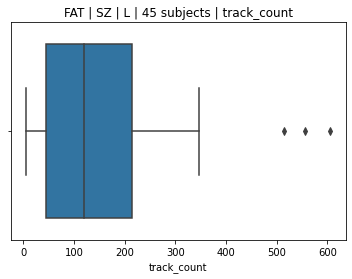

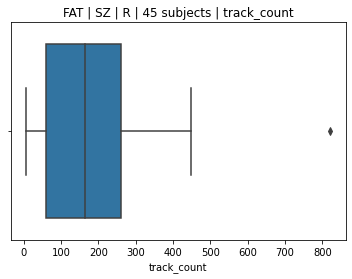

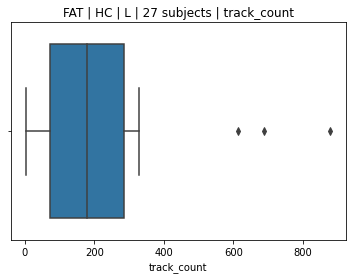

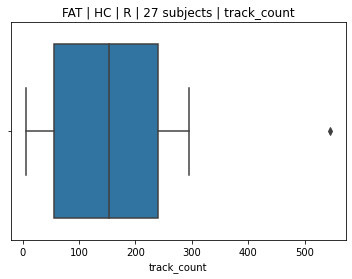

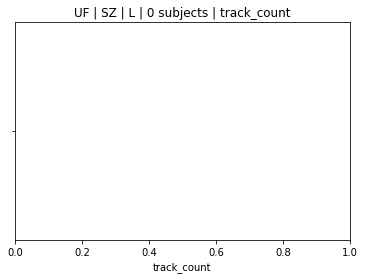

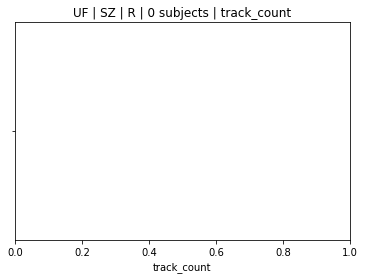

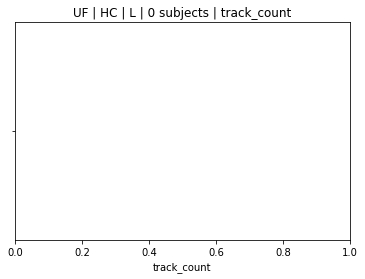

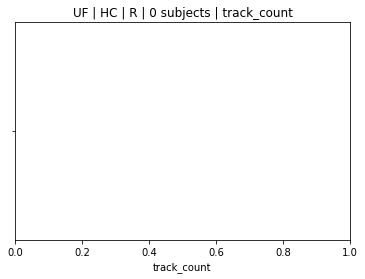

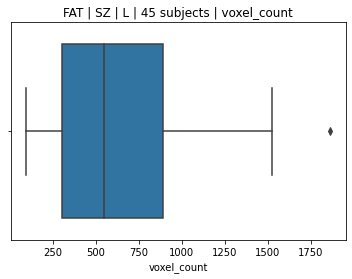

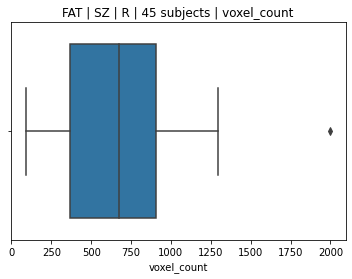

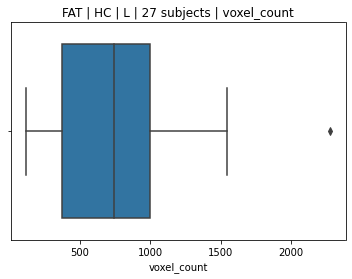

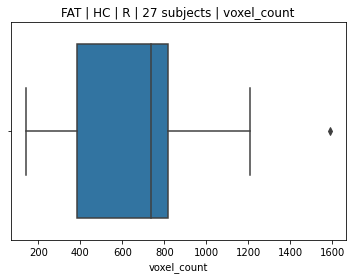

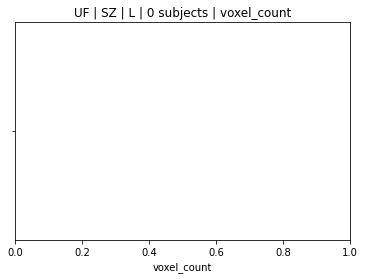

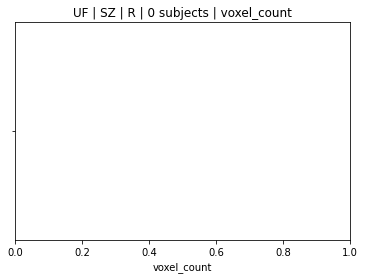

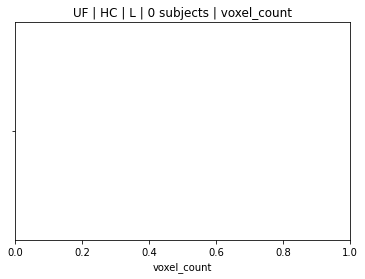

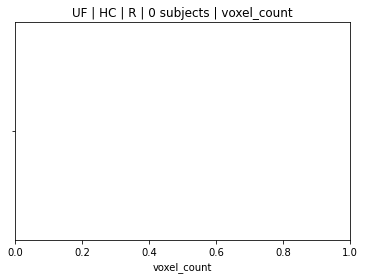

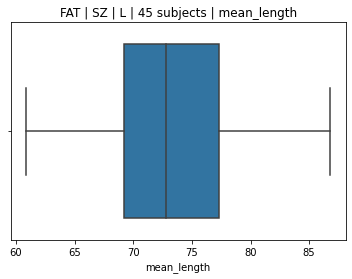

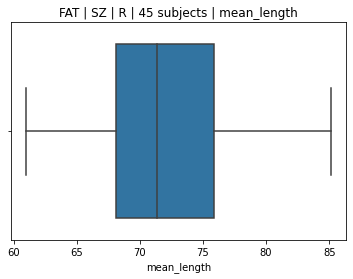

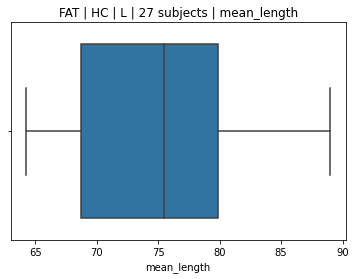

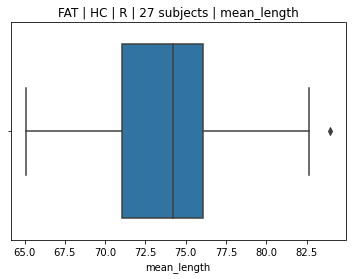

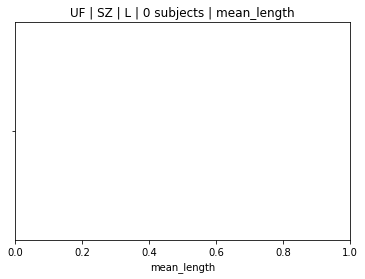

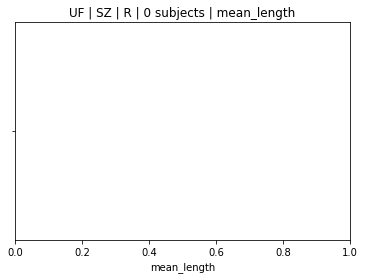

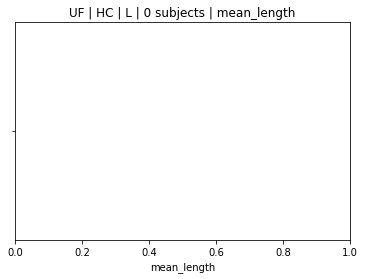

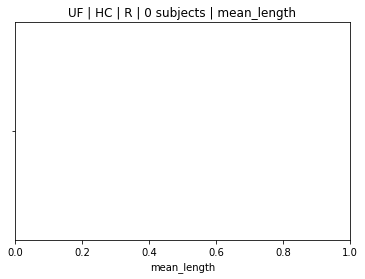

In [256]:
for measure in measures:
    for TRACT in TRACTS:
        for COND in CONDS:
            for SIDE in SIDES:
                sub = cldf[(cldf.condition == COND) & (cldf.tract == TRACT) & (cldf.side == SIDE)]
                sns.boxplot(x = measure, data = sub)
                plt.title(f'''{TRACT} | {COND} | {SIDE} | {len(sub)} subjects | {measure}''')
                plt.show()